# <font color='#097873'>**Face Recognition**</font> 👧🏻 👩🏽🧔🏿🧑🏻‍🦱👱🏻‍♀️ 

## <span style="font-size: 0.9em;">🔴</span> **Import**

In [1]:
import numpy as np
import pandas as pd
import csv
import cv2
from glob import glob
import os
import math
import pickle
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, hog

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# <font color='#ab079c'>**Face Recognition (Closed-Set)**</font>  

## <span style="font-size: 0.9em;">🟣</span> **Load ORL Face Dataset**

https://www.kaggle.com/datasets/kasikrit/att-database-of-faces
```plaintext
/faces_dataset/
    s1/
        1.pgm
        2.pgm
        ...
        10.pgm
    s2/
        1.pgm
        2.pgm
        ...
        10.pgm
    ...
    s40/
        1.pgm
        2.pgm
        ...
        10.pgm
```

In [2]:
def extract_subject_image_number(file_path):
    parts = file_path.split('/')
    subject_num = int(parts[1][1:])  # Extract subject number (e.g., '15' from 's15')
    image_num = int(parts[2].split('.')[0])  # Extract image number (e.g., '1' from '1.pgm')
    return subject_num, image_num

def save_to_csv(sorted_files, csv_file_path, root_dir):
    data = []
    for file in sorted_files:
        subject_num, _ = extract_subject_image_number(file)
        relative_path = os.path.relpath(file, root_dir) # Extract relative path
        data.append({"file_name": relative_path, "target": subject_num})  
    
    df = pd.DataFrame(data)
    df.to_csv(csv_file_path, index=False)

root_dir = 'faces_dataset'
files = glob(os.path.join(root_dir, "*/*.pgm"))
sorted_files = sorted(files, key=extract_subject_image_number)

csv_file_path = os.path.join(root_dir, 'faces.csv')
save_to_csv(sorted_files, csv_file_path, root_dir)

In [3]:
class FaceDataset:
    def __init__(self, root_dir, csv_file):
        self.root_dir = root_dir
        csv_file_path = os.path.join(root_dir, csv_file)
        self.df = pd.read_csv(csv_file_path)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.root_dir, row['file_name'])
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 
        target = row['target']
        return image, target

face_dataset = FaceDataset(root_dir, 'faces.csv')
print(f'Total number of images: {len(face_dataset)}, Image size{face_dataset[0][0].shape}')

Total number of images: 400, Image size(112, 92)


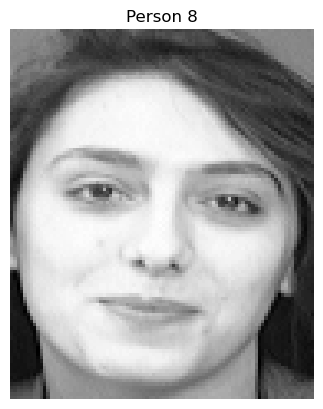

In [4]:
idx = 77
plt.imshow(face_dataset[idx][0], cmap='gray')
plt.title(f'Person {face_dataset[idx][1]}')
plt.axis('off');

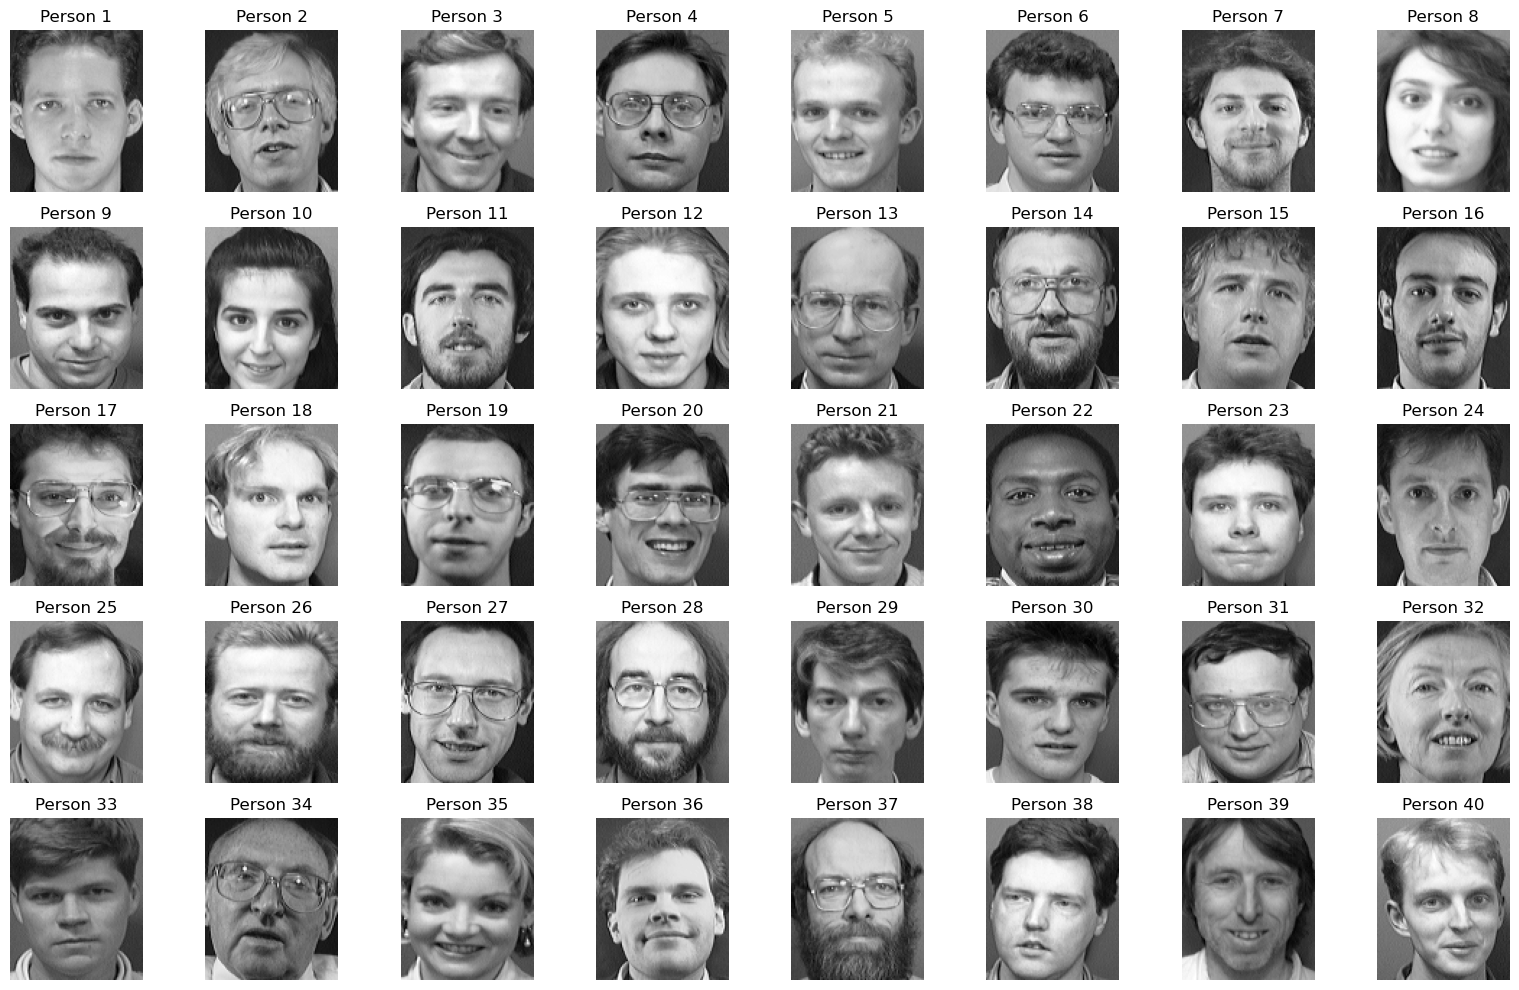

In [5]:
def visualize_faces(dataset, images_per_subject=10, grid_cols=8):
    num_subjects = len(dataset) // images_per_subject  
    grid_rows = math.ceil(num_subjects / grid_cols)  

    plt.figure(figsize=(grid_cols * 2, grid_rows * 2))  

    for i in range(num_subjects):
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(dataset[i * images_per_subject][0], cmap='gray')  # Access the first image of each subject
        plt.title(f'Person {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_faces(face_dataset, images_per_subject=10, grid_cols=8)

##### 🟤 Split the dataset into training and testing sets

In [6]:
def get_train_test_split(df, train_size=0.8, random_seed=42):
    train_data = []
    test_data = []

    grouped = df.groupby('target')
    
    for subject, group in grouped:
        if len(group) != 10:
            raise ValueError(f"Subject {subject} does not have exactly 10 images.")

        np.random.seed(random_seed)
        indices = np.arange(len(group))
        train_indices = np.random.choice(indices, size=int(train_size * len(indices)), replace=False)
        test_indices = np.array(list(set(indices) - set(train_indices)))

        train_subset = group.iloc[train_indices]
        test_subset = group.iloc[test_indices]

        train_data.append(train_subset)
        test_data.append(test_subset)
    
    train_df = pd.concat(train_data, ignore_index=True)
    test_df = pd.concat(test_data, ignore_index=True)
    
    return train_df, test_df

csv_file_path = os.path.join(root_dir, 'faces.csv')
df = pd.read_csv(csv_file_path)

train_df, test_df = get_train_test_split(df)

train_csv_path = os.path.join(root_dir, 'train_faces.csv')
test_csv_path = os.path.join(root_dir, 'test_faces.csv')

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")

Train set size: 320, Test set size: 80


In [7]:
train_set = FaceDataset(root_dir, 'train_faces.csv')
test_set = FaceDataset(root_dir, 'test_faces.csv')
train_set[0]

(array([[42, 41, 44, ..., 50, 49, 57],
        [41, 41, 43, ..., 51, 53, 53],
        [54, 40, 43, ..., 49, 52, 53],
        ...,
        [38, 37, 36, ..., 40, 43, 40],
        [38, 36, 37, ..., 44, 42, 39],
        [37, 39, 37, ..., 42, 43, 41]], dtype=uint8),
 1)

In [8]:
def get_image_label(dataset):
    images = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = get_image_label(train_set)
test_images, test_labels = get_image_label(test_set)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

Train images shape: (320, 112, 92), Train labels shape: (320,)
Test images shape: (80, 112, 92), Test labels shape: (80,)


## <span style="font-size: 0.9em;">🔵</span> **Feature extraction**

In [9]:
def extract_features(image, feature_method="lbp"):
    if feature_method == "lbp":
        radius = 3
        n_points = 8 * radius
        return local_binary_pattern(image, n_points, radius, method='uniform').flatten()
        
    elif feature_method == "hog":
        return hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        
    else:
        raise ValueError("Unsupported feature extraction method!")

In [10]:
feature_method="hog" 
train_features, test_features = [], []

for image in train_images:
    features = extract_features(image, feature_method)
    train_features.append(features)

for image in test_images:
    features = extract_features(image, feature_method)
    test_features.append(features)

X_train, X_test = np.array(train_features), np.array(test_features)
y_train, y_test = train_labels, test_labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 4680), (320,), (80, 4680), (80,))

##### 🟡   Feature Reduction with PCA

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 200  
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

Reduced X_train shape: (320, 200)
Reduced X_test shape: (80, 200)


## <span style="font-size: 0.9em;">🟠</span> **Classification**

In [12]:
model = SVC(kernel="linear", random_state=42)

model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 98.75%


## <span style="font-size: 0.9em;">⚪</span> **Visualization of Results**

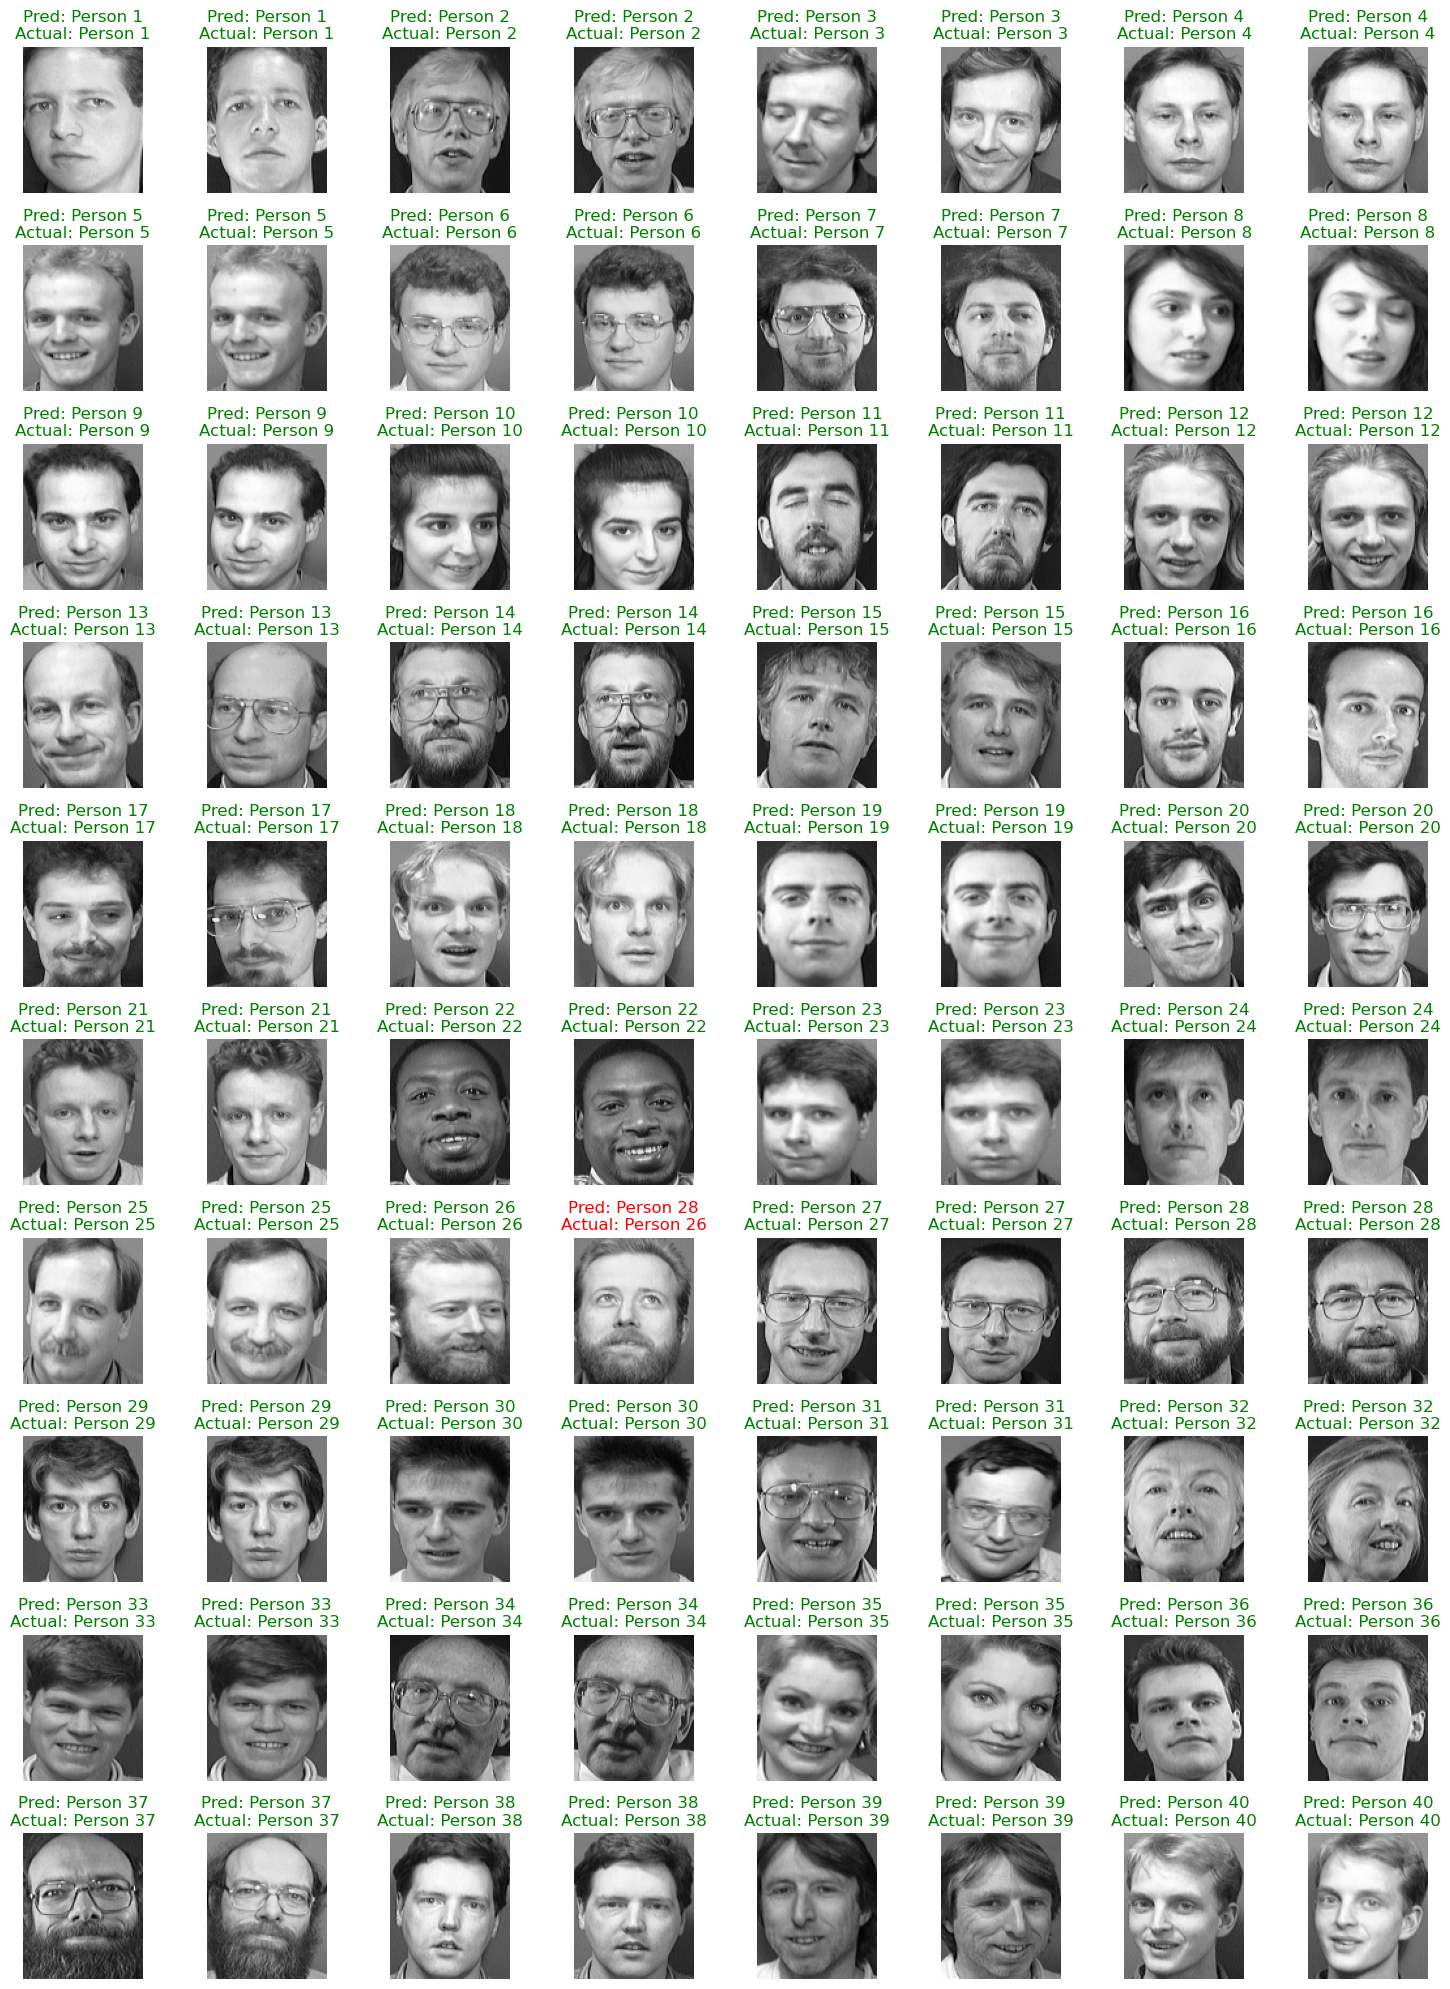

In [13]:
plt.figure(figsize=(15, 20))

for i, (image, pred, target) in enumerate(zip(test_images, y_pred, y_test)):
    plt.subplot(10, 8, i + 1)
    plt.imshow(image, cmap='gray')
    
    color = 'green' if pred == target else 'red'
    plt.title(f'Pred: Person {pred}\nActual: Person {target}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# <font color='#059705'>**Face Recognition (Open-Set)**</font>  

## <span style="font-size: 0.9em;">🟣</span> **Save Feature Vectors as a Gallery**

In [14]:
# Save gallery feature vectors and labels
def save_gallery(features, labels, file_path="gallery/gallery.pkl"):
    gallery = {"features": features, "labels": labels}
    with open(file_path, "wb") as f:
        pickle.dump(gallery, f)
    print(f"Gallery saved at {file_path}")

# Load gallery
def load_gallery(file_path="gallery/gallery.pkl"):
    with open(file_path, "rb") as f:
        gallery = pickle.load(f)
    print(f"Gallery loaded from {file_path}")
    return gallery

# After extracting features from training data
save_gallery(X_train_reduced, y_train, "gallery/gallery.pkl")

Gallery saved at gallery/gallery.pkl


## <span style="font-size: 0.9em;">🔵</span> **Extract Features for a New Person**

In [15]:
def add_to_gallery(new_image, new_label, gallery_file="gallery/gallery.pkl"):
    features = extract_features(new_image, feature_method)
    features = scaler.transform([features])  
    features = pca.transform(features)      
    
    gallery = load_gallery(gallery_file)
    gallery["features"] = np.vstack([gallery["features"], features])
    gallery["labels"] = np.append(gallery["labels"], new_label)
    
    # Save updated gallery
    save_gallery(gallery["features"], gallery["labels"], gallery_file)

## <span style="font-size: 0.9em;">🟠</span> **Matching Block Using Euclidean Distance**

In [16]:
def recognize_person(query_image, gallery_file="gallery/gallery.pkl", threshold=65):
    features = extract_features(query_image, feature_method)
    features = scaler.transform([features])  
    features = pca.transform(features)     

    gallery = load_gallery(gallery_file)
    gallery_features = gallery["features"]
    gallery_labels = gallery["labels"]
    
    distances = np.linalg.norm(gallery_features - features, axis=1) # Euclidean distances
    min_distance = np.min(distances)
    
    if min_distance <= threshold:
        recognized_label = gallery_labels[np.argmin(distances)]
        print(f"Recognized as label: {recognized_label} (distance: {min_distance:.2f})")
    else:
        recognized_label = -1  # Unknown
        print(f"Person not recognized (distance: {min_distance:.2f})")
    
    return recognized_label

In [23]:
save_gallery(X_train_reduced, y_train)

# Resize the image
def preprocess_image(image, target_size=(92, 112)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

# Add a new person
new_image = cv2.imread('incoming/s41_1.png', cv2.IMREAD_GRAYSCALE)
new_image = preprocess_image(new_image)

new_label = 41  
add_to_gallery(new_image, new_label)

# Recognize a query image
query_image = cv2.imread('incoming/s41_3.png', cv2.IMREAD_GRAYSCALE)
query_image = preprocess_image(query_image)
recognized_label = recognize_person(query_image)

Gallery saved at gallery/gallery.pkl
Gallery loaded from gallery/gallery.pkl
Gallery saved at gallery/gallery.pkl
Gallery loaded from gallery/gallery.pkl
Recognized as label: 41 (distance: 59.98)


## <span style="font-size: 0.9em;">⚪</span> **Visualization of Results**

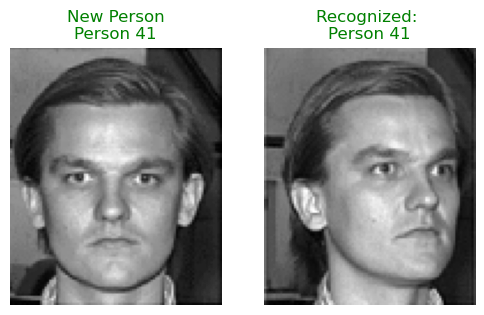

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(6, 12))
axes[0].imshow(new_image, cmap='gray')
axes[0].set_title(f'New Person\nPerson {new_label}', color='green')
axes[0].axis('off');
axes[1].imshow(query_image, cmap='gray')
axes[1].set_title(f'Recognized: \nPerson {recognized_label}', color='green')
axes[1].axis('off');

Gallery loaded from gallery/gallery.pkl
Recognized as label: 33 (distance: 24.67)


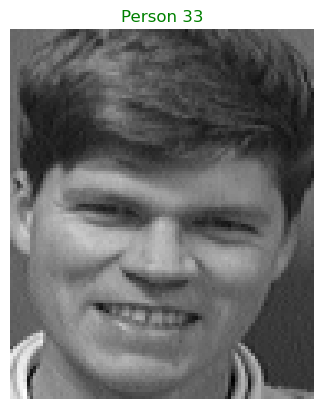

In [26]:
query_image = test_images[64]
recognized_label = recognize_person(query_image)

plt.imshow(query_image, cmap='gray')
plt.title(f'Person {recognized_label}', color = 'green' if recognized_label != -1 else 'red')
plt.axis('off');